# This notebook explores valley bottom extraction methods

existing:

    - V-BET:
    - Geomorphons (WhiteBoxTools implementation)
    - CostAccumulation:
    - Slope Threshold:
    - Height Threshold:
    - FluvialCorridor
    - Valley Confinement Algorithm

totest:

- SurfaceVoronoi
- CostAccumulation delineation (danish paper, depth to water, downslope distance to stream, elevation above stream, wetness index, hillslope extraction)
- Adaptive threshold of slope and height
- curvature and wavelet analysis (smooth first with gaussian), cross corrolate wavelet with curvature (oskin)
- nonlinear diffusion hillsope models to get sense of different cross sections for river valleys (oskin)
- topographic openness (oskin)
- get median aspect of valley to help delineate slope and hillslope?
  

In [4]:
from dataclasses import dataclass
import glob
import os
import shutil

import leafmap.leafmap as leafmap
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

import numpy as np
import pandas as pd
import py3dep 
from pynhd import NHD
import rasterio as rio
from rasterio.coords import BoundingBox
from rasterio import Affine
from rasterio.plot import show
import rioxarray
import whitebox

In [5]:

@dataclass
class Raster:
    data: np.ndarray
    metadata: dict
    bounds: BoundingBox
    
    @classmethod
    def from_file(cls, raster_file):
        with rio.open(raster_file) as dataset:
            data = dataset.read(1)
            metadata = dataset.meta.copy()
            bounds = dataset.bounds
                
            if "float" in str(data.dtype):
                metadata['nodata'] = np.nan if metadata['nodata'] is None else metadata['nodata']
                
                data[data > 3.0e38] = metadata['nodata']
                data[data < -3.0e38] = metadata['nodata']
                
            return cls(data, metadata, bounds)
        
    @classmethod
    def from_xarray_rio(cls, xarr):
        metadata = {
            'count': xarr.rio.count,
            'height': xarr.rio.height,
            'width': xarr.rio.width,
            'dtype': str(xarr.dtype),
            'crs': xarr.rio.crs,
            'nodata': xarr.rio.nodata,
            'transform': xarr.rio.transform()
        }
        data = xarr.values
        bbox = BoundingBox(*xarr.rio.bounds())
        return cls(data, metadata, bounds)
        
    def to_file(self, output_file):
        with rio.open(output_file, 'w', **self.metadata) as dataset:
            dataset.write(self.data,1)
                
    def zero_to_nodata(self):
        self.data[self.data == 0] = self.metadata['nodata']
        self.data[self.data == 0] = self.metadata['nodata']

    def plot(self, ax=None):
        show(self.data, transform = self.metadata['transform'], ax=ax)

In [6]:
# paths and configuration
valley_polygons_path = "../raw_data/sample_valley_polygons/sample_valleys.geojson"

working_directory = "../data/valley_bottom_testing/"

## Get DEM and Flowline Data (run once)

In [89]:
if os.path.isdir(working_directory):
    shutil.rmtree(working_directory)
os.mkdir(working_directory)

In [90]:
gdf = gpd.read_file(valley_polygons_path, driver='GeoJSON')
gdf = gdf[["layer", "geometry"]]
gdf = gdf.explode('geometry', index_parts=False)
gdf

,layer,geometry
0,russian_confined,"POLYGON ((6257387.991 1939912.155, 6254095.915..."
1,russian_large,"POLYGON ((6231409.111 1908836.263, 6231409.111..."
2,russian_med,"POLYGON ((6270261.608 1935260.309, 6270261.608..."
3,russian_partly_confined,"POLYGON ((6246509.827 1923216.026, 6246829.773..."
4,russian_small,"POLYGON ((6292388.399 1925695.607, 6292388.399..."
5,russian_unconfined,"POLYGON ((6273705.237 1945469.112, 6272021.311..."
6,santa_ynez_confined,"POLYGON ((7070336.506 552287.319, 7070800.663 ..."
7,santa_ynez_large,"POLYGON ((7071756.826 517740.130, 7071756.826 ..."
8,santa_ynez_med,"POLYGON ((7025749.607 485509.084, 7025749.607 ..."
9,santa_ynez_partly_confined,"POLYGON ((7082898.909 545930.692, 7083446.614 ..."


In [91]:
# get dems and save to files
def get_dem(geometry):
    dem = py3dep.get_map("DEM", geometry, resolution=10, geo_crs="epsg:6418", crs="epsg:4326")
    dem = dem.rio.reproject(6418)
    dem = Raster.from_xarray_rio(dem)
    return dem

dem_filepaths = []
for index,row in gdf.iterrows():
    print(f"getting dem for {row['layer']}")
    dem = get_dem(row['geometry'])
    fname = os.path.join(working_directory, f"{row['layer']}-dem30m.tif")
    dem_filepaths.append(fname)
    dem.to_file(fname)

getting dem for russian_confined
getting dem for russian_large
getting dem for russian_med
getting dem for russian_partly_confined
getting dem for russian_small
getting dem for russian_unconfined
getting dem for santa_ynez_confined
getting dem for santa_ynez_large
getting dem for santa_ynez_med
getting dem for santa_ynez_partly_confined
getting dem for santa_ynez_small
getting dem for santa_ynez_unconfined
getting dem for sierra_confined
getting dem for sierra_large
getting dem for sierra_med
getting dem for sierra_partly_confined
getting dem for sierra_small
getting dem for sierra_unconfined


In [93]:
# get NHD flowlines
def get_flowlines(geometry):
    fields = [
        'COMID',
    ]

    nhd = NHD('flowline_mr', outfields = fields)
    try:
        flowlines = nhd.bygeom(geometry, geo_crs=6418)
        flowlines = flowlines.to_crs(6418)
    except Exception as e:
        flowlines = None
    return flowlines
    
flowline_filepaths = []
for index,row in gdf.iterrows():
    print(f"getting flowlines for {row['layer']}")
    flowlines = get_flowlines(row['geometry'])
    fname = os.path.join(working_directory, f"{row['layer']}-flowlines.geojson")
    if flowlines is not None:
        flowlines.to_file(fname, driver="GeoJSON")
        flowline_filepaths.append(fname)
    else:
        print(f"\tno flowlines for {row['layer']}")
        flowline_filepaths.append(None)

getting flowlines for russian_confined
getting flowlines for russian_large
getting flowlines for russian_med
getting flowlines for russian_partly_confined
getting flowlines for russian_small
getting flowlines for russian_unconfined
getting flowlines for santa_ynez_confined
	no flowlines for santa_ynez_confined
getting flowlines for santa_ynez_large
getting flowlines for santa_ynez_med
getting flowlines for santa_ynez_partly_confined
getting flowlines for santa_ynez_small
getting flowlines for santa_ynez_unconfined
getting flowlines for sierra_confined
getting flowlines for sierra_large
getting flowlines for sierra_med
getting flowlines for sierra_partly_confined
getting flowlines for sierra_small
getting flowlines for sierra_unconfined


In [94]:
gdf["dem_filepath"] = dem_filepaths
gdf["flowline_filepath"] = flowline_filepaths
gdf.to_file(os.path.join(working_directory, 'manifest.geojson'), driver='GeoJSON')  

In [95]:
# all leafmap stuff seems to be in EPSG:4326
# plot Russian med

dem_fpath = gdf.iloc[2]["dem_filepath"]
flow_fpath = gdf.iloc[2]["flowline_filepath"]

m = leafmap.Map(center=[38.5, -122.95], zoom=12)
m.add_gdf(gpd.read_file(flow_fpath), layer_name='Flowlines')
m.add_raster(dem_fpath, cmap="terrain", layer_name="DEM")

m

Map(center=[38.5, -122.95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

# Load Data

In [7]:
manifest = gpd.read_file(os.path.join(working_directory, "manifest.geojson"))
manifest

,layer,dem_filepath,flowline_filepath,geometry
0,russian_confined,../data/valley_bottom_testing/russian_confined...,../data/valley_bottom_testing/russian_confined...,"POLYGON ((6257387.991 1939912.155, 6254095.915..."
1,russian_large,../data/valley_bottom_testing/russian_large-de...,../data/valley_bottom_testing/russian_large-fl...,"POLYGON ((6231409.111 1908836.263, 6231409.111..."
2,russian_med,../data/valley_bottom_testing/russian_med-dem3...,../data/valley_bottom_testing/russian_med-flow...,"POLYGON ((6270261.608 1935260.309, 6270261.608..."
3,russian_partly_confined,../data/valley_bottom_testing/russian_partly_c...,../data/valley_bottom_testing/russian_partly_c...,"POLYGON ((6246509.827 1923216.026, 6246829.773..."
4,russian_small,../data/valley_bottom_testing/russian_small-de...,../data/valley_bottom_testing/russian_small-fl...,"POLYGON ((6292388.399 1925695.607, 6292388.399..."
5,russian_unconfined,../data/valley_bottom_testing/russian_unconfin...,../data/valley_bottom_testing/russian_unconfin...,"POLYGON ((6273705.237 1945469.112, 6272021.311..."
6,santa_ynez_confined,../data/valley_bottom_testing/santa_ynez_confi...,NaN,"POLYGON ((7070336.506 552287.319, 7070800.663 ..."
7,santa_ynez_large,../data/valley_bottom_testing/santa_ynez_large...,../data/valley_bottom_testing/santa_ynez_large...,"POLYGON ((7071756.826 517740.130, 7071756.826 ..."
8,santa_ynez_med,../data/valley_bottom_testing/santa_ynez_med-d...,../data/valley_bottom_testing/santa_ynez_med-f...,"POLYGON ((7025749.607 485509.084, 7025749.607 ..."
9,santa_ynez_partly_confined,../data/valley_bottom_testing/santa_ynez_partl...,../data/valley_bottom_testing/santa_ynez_partl...,"POLYGON ((7082898.909 545930.692, 7083446.614 ..."


# Geomorphons

paper: https://www.sciencedirect.com/science/article/pii/S0169555X12005028

whiteboxtools implementation: https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html#geomorphons

classes picture:


In [65]:
wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir("/Users/arthurkoehl/opt/WBT/")

wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()
def my_callback(value):
    if "Elapsed Time" in value:
        print(value)

In [62]:
# geomorphons
geomorphon_filepaths = []
for index,row in manifest.iterrows():
    wbt.geomorphons(
        os.path.basename(row['dem_filepath']), 
        f"{row['layer']}-geomorphons.tif", 
        search=50, 
        threshold=0.0, 
        fdist=0, 
        skip=0, 
        forms=True, 
        residuals=False,
        callback=my_callback
    )
    geomorphon_filepaths.append(os.path.join(working_directory, f"{row['layer']}-geomorphons.tif"))

manifest['geomorphons'] = geomorphon_filepaths
manifest

./whitebox_tools --run="Geomorphons" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/valley_bottom_testing" --dem='russian_confined-dem30m.tif' --output='russian_confined-geomorphons.tif' --search=50 --threshold=0.0 --fdist=0 --skip=0 --forms -v --compress_rasters=False

****************************
* Welcome to Geomorphons   *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Generating global ternary codes...
Computing geomorphons...
Saving data...
Output file written
Elapsed Time (excluding I/O): 1.154s
./whitebox_tools --run="Geomorphons" --wd="/Users/arthurkoehl/programs/pasternack/valleys/data/valley_bottom_testing" --dem='russian_large-dem30m.tif' --output='russian_large-geomorphons.tif' --search=50 --threshold=0.0 --fdist=0 --skip=0 --forms -v --compress_rasters=False

****************************
* Welcome to Geomorphons   *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Read

,layer,dem_filepath,flowline_filepath,geometry,geomorphons
0,russian_confined,../data/valley_bottom_testing/russian_confined...,../data/valley_bottom_testing/russian_confined...,"POLYGON ((6257387.991 1939912.155, 6254095.915...",../data/valley_bottom_testing/russian_confined...
1,russian_large,../data/valley_bottom_testing/russian_large-de...,../data/valley_bottom_testing/russian_large-fl...,"POLYGON ((6231409.111 1908836.263, 6231409.111...",../data/valley_bottom_testing/russian_large-ge...
2,russian_med,../data/valley_bottom_testing/russian_med-dem3...,../data/valley_bottom_testing/russian_med-flow...,"POLYGON ((6270261.608 1935260.309, 6270261.608...",../data/valley_bottom_testing/russian_med-geom...
3,russian_partly_confined,../data/valley_bottom_testing/russian_partly_c...,../data/valley_bottom_testing/russian_partly_c...,"POLYGON ((6246509.827 1923216.026, 6246829.773...",../data/valley_bottom_testing/russian_partly_c...
4,russian_small,../data/valley_bottom_testing/russian_small-de...,../data/valley_bottom_testing/russian_small-fl...,"POLYGON ((6292388.399 1925695.607, 6292388.399...",../data/valley_bottom_testing/russian_small-ge...
5,russian_unconfined,../data/valley_bottom_testing/russian_unconfin...,../data/valley_bottom_testing/russian_unconfin...,"POLYGON ((6273705.237 1945469.112, 6272021.311...",../data/valley_bottom_testing/russian_unconfin...
6,santa_ynez_confined,../data/valley_bottom_testing/santa_ynez_confi...,NaN,"POLYGON ((7070336.506 552287.319, 7070800.663 ...",../data/valley_bottom_testing/santa_ynez_confi...
7,santa_ynez_large,../data/valley_bottom_testing/santa_ynez_large...,../data/valley_bottom_testing/santa_ynez_large...,"POLYGON ((7071756.826 517740.130, 7071756.826 ...",../data/valley_bottom_testing/santa_ynez_large...
8,santa_ynez_med,../data/valley_bottom_testing/santa_ynez_med-d...,../data/valley_bottom_testing/santa_ynez_med-f...,"POLYGON ((7025749.607 485509.084, 7025749.607 ...",../data/valley_bottom_testing/santa_ynez_med-g...
9,santa_ynez_partly_confined,../data/valley_bottom_testing/santa_ynez_partl...,../data/valley_bottom_testing/santa_ynez_partl...,"POLYGON ((7082898.909 545930.692, 7083446.614 ...",../data/valley_bottom_testing/santa_ynez_partl...


- try larger search distance parameter
- try running on relative elevation model
- test with and without smoothing of the DEM (filter or https://www.whiteboxgeo.com/manual/wbt_book/available_tools/geomorphometric_analysis.html?highlight=feature%20preserving#featurepreservingsmoothing and then of the geomorphon output (median filter)
- combine geomorphon with slope with cost to channel accumulation delineation

clustering based on features for each pixel: (geodesic to channel, slope, curviture, geomorphon, hand, dtw?, relative topographic position)

In [64]:
geomorphons_classes = {
    1: 'Flat',
    2: 'Peak (summit)',
    3:	"Ridge",
    4:	'Shoulder',
    5:	'Spur (convex)',
    6:	'Slope',
    7:	'Hollow (concave)',
    8:	'Footslope',
    9:	'Valley',
    10:	'Pit (depression)',
}

# DEM Preprocessing

Filters:
- Mean Filter
- Median Filter
- Gaussian
- Feature Preserving Filter (whiteboxtools)

In [51]:
manifest

,layer,dem_filepath,flowline_filepath,geometry
0,russian_confined,../data/valley_bottom_testing/russian_confined...,../data/valley_bottom_testing/russian_confined...,"POLYGON ((6257387.991 1939912.155, 6254095.915..."
1,russian_large,../data/valley_bottom_testing/russian_large-de...,../data/valley_bottom_testing/russian_large-fl...,"POLYGON ((6231409.111 1908836.263, 6231409.111..."
2,russian_med,../data/valley_bottom_testing/russian_med-dem3...,../data/valley_bottom_testing/russian_med-flow...,"POLYGON ((6270261.608 1935260.309, 6270261.608..."
3,russian_partly_confined,../data/valley_bottom_testing/russian_partly_c...,../data/valley_bottom_testing/russian_partly_c...,"POLYGON ((6246509.827 1923216.026, 6246829.773..."
4,russian_small,../data/valley_bottom_testing/russian_small-de...,../data/valley_bottom_testing/russian_small-fl...,"POLYGON ((6292388.399 1925695.607, 6292388.399..."
5,russian_unconfined,../data/valley_bottom_testing/russian_unconfin...,../data/valley_bottom_testing/russian_unconfin...,"POLYGON ((6273705.237 1945469.112, 6272021.311..."
6,santa_ynez_confined,../data/valley_bottom_testing/santa_ynez_confi...,NaN,"POLYGON ((7070336.506 552287.319, 7070800.663 ..."
7,santa_ynez_large,../data/valley_bottom_testing/santa_ynez_large...,../data/valley_bottom_testing/santa_ynez_large...,"POLYGON ((7071756.826 517740.130, 7071756.826 ..."
8,santa_ynez_med,../data/valley_bottom_testing/santa_ynez_med-d...,../data/valley_bottom_testing/santa_ynez_med-f...,"POLYGON ((7025749.607 485509.084, 7025749.607 ..."
9,santa_ynez_partly_confined,../data/valley_bottom_testing/santa_ynez_partl...,../data/valley_bottom_testing/santa_ynez_partl...,"POLYGON ((7082898.909 545930.692, 7083446.614 ..."


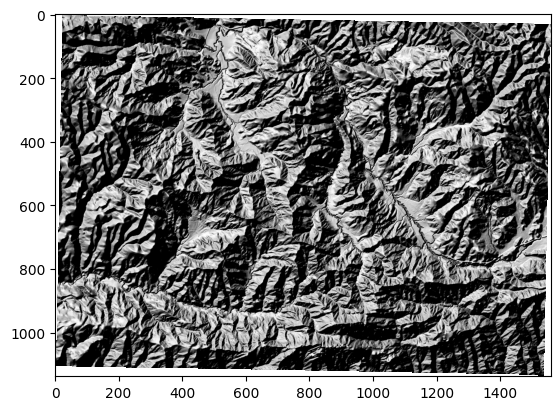

In [60]:
import scipy
from matplotlib.colors import LightSource

# use scipy to guassian filter
dem_fpath = manifest["dem_filepath"][manifest["layer"] == "santa_ynez_med"].iloc[0]

raster = Raster.from_file(dem_fpath)
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(raster.data)
plt.imshow(hillshade, cmap="gray")

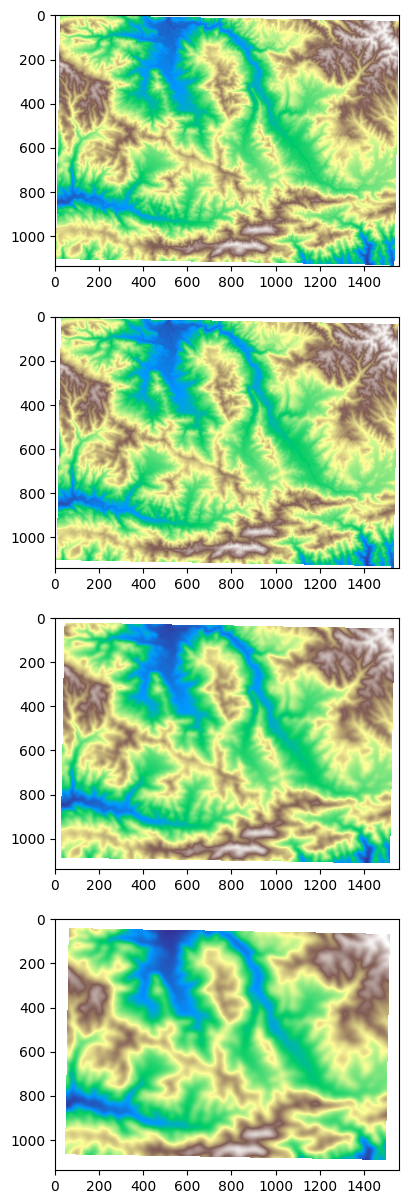

In [61]:
f, axs = plt.subplots(4,1, figsize=(5,15))
axs[0].imshow(raster.data, cmap="terrain")
axs[1].imshow(scipy.ndimage.gaussian_filter(raster.data, 1), cmap="terrain")
axs[2].imshow(scipy.ndimage.gaussian_filter(raster.data, 5), cmap="terrain")
axs[3].imshow(scipy.ndimage.gaussian_filter(raster.data, 10), cmap="terrain")

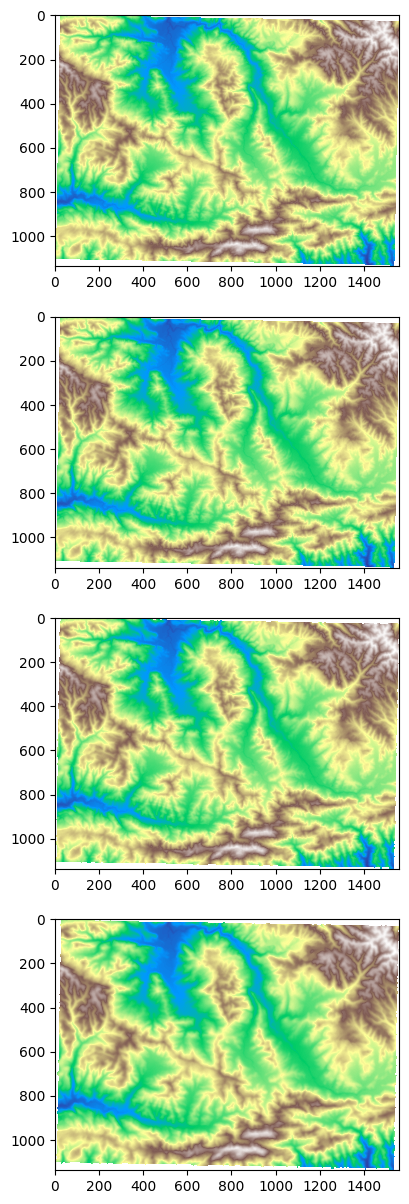

In [62]:
# median filter
f, axs = plt.subplots(4,1, figsize=(5,15))
axs[0].imshow(raster.data, cmap="terrain")
axs[1].imshow(scipy.ndimage.median_filter(raster.data, 1), cmap="terrain")
axs[2].imshow(scipy.ndimage.median_filter(raster.data, 5), cmap="terrain")
axs[3].imshow(scipy.ndimage.median_filter(raster.data, 10), cmap="terrain")

# Curvature and Slope Breaks

In [17]:
def get_nearest_vertices(point, linestring):
    line_coords = linestring.coords
    distances = [point.distance(Point(x, y)) for x, y in line_coords]
    nearest_indices = np.argsort(distances)[:2]
    nearest_vertices = [Point(line_coords[int(i)]) for i in nearest_indices]
    return nearest_vertices

def sample_point_on_perpendicular_line(point, A, B, alpha):
    length = A.distance(B)
    x = point.x + alpha * (A.y - B.y) / length
    y = point.y + alpha * (B.x - A.x) / length
    return Point(x,y)

def get_cross_section(point, linestring, width, alpha_increment, raster):
    A,B = get_nearest_vertices(point, linestring)
    npoints = width // alpha_increment
    positive_alphas = [alpha_increment * n for n in range(npoints+1)]
    negative_alphas = [-i for i in positive_alphas]
    alphas = negative_alphas + positive_alphas
    sample_points = [sample_point_on_perpendicular_line(point, A, B, alpha) for alpha in alphas]
    values = [raster.sel(x=point.x, y=point.y, method='nearest').values for point in sample_points]
    return (alphas,values)

In [18]:
dem_fpath = manifest["dem_filepath"][manifest["layer"] == "russian_partly_confined"].iloc[0]
raster = Raster.from_file(dem_fpath)

flowlines_fpath = manifest["flowline_filepath"][manifest["layer"] == "russian_partly_confined"].iloc[0]
flowlines = gpd.read_file(flowlines_fpath)
flowlines

,COMID,geometry
0,8272953,"LINESTRING (6247418.101 1923649.539, 6246987.8..."
1,8272951,"LINESTRING (6248104.882 1927144.850, 6247533.4..."
2,8276513,"LINESTRING (6258773.467 1926632.489, 6258738.9..."
3,8272789,"LINESTRING (6268679.066 1914146.618, 6268098.0..."
4,8272949,"LINESTRING (6247749.730 1924010.084, 6247720.9..."
5,8272773,"LINESTRING (6252298.165 1933141.210, 6252062.6..."
6,8272939,"LINESTRING (6248123.818 1927290.232, 6248154.8..."


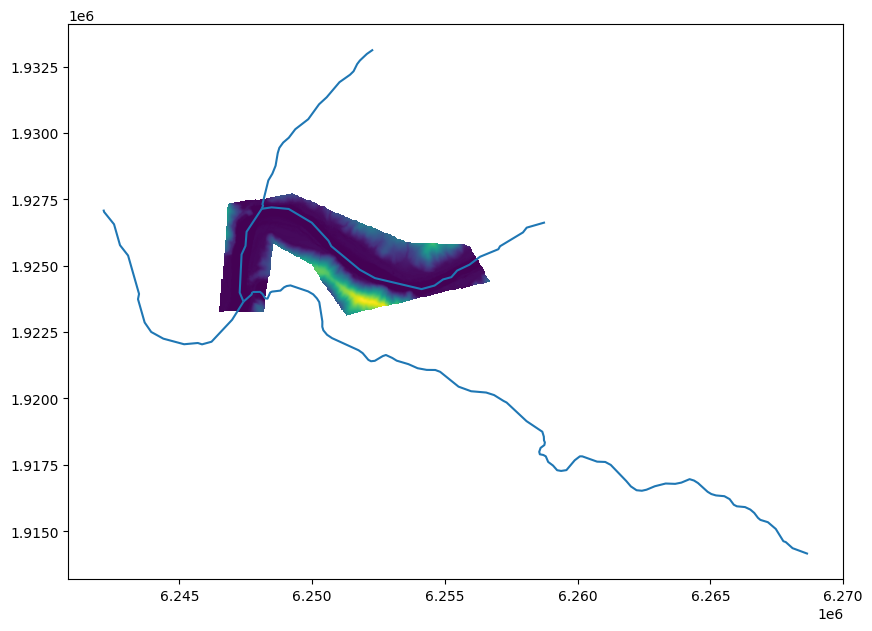

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
raster.plot(ax=ax)
flowlines.plot(ax=ax)
plt.show()

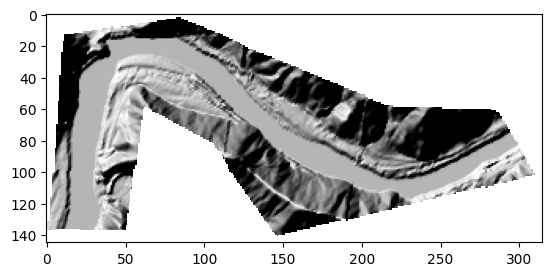

In [20]:
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(raster.data)
plt.imshow(hillshade, cmap="gray")

In [21]:
from shapely import unary_union
from shapely.geometry import box, LineString, MultiPoint
from shapely.ops import split
from shapely.ops import snap

def random_cmap(length=10):
    vals = np.linspace(0,1,length)
    np.random.shuffle(vals)
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    return cmap

def segment(line, length=500, method="remainder"):
    # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
    # https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
    
    if method not in ['remainder', 'equal']:
        raise ValueError(f"method must be 'remainder' or 'equal' when {method} was provided")
    
    if method == "remainder":
        distances = np.arange(0, line.length, length)
    elif method == "equal":
        nparts = line.length // length
        if nparts == 0:
            distances = np.arange(0, line.length, line.length)
        else:        
            distances = np.arange(0, line.length, line.length/nparts)
        
    points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
    points = unary_union(points)
    snapped = snap(line, points, tolerance=0.01) 
    return list(split(snapped, points).geoms)

<Axes: >

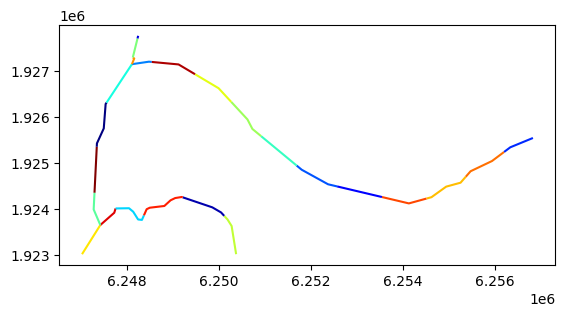

In [22]:
# split line segments
segments = flowlines.copy()
segments['split'] = segments['geometry'].apply(segment, length=1000, method='remainder')
segments = segments.explode('split')
segments['geometry'] = segments['split']
segments = segments[['geometry', 'COMID']]

segments = segments.clip(raster.bounds)

segments.plot(cmap=random_cmap(25))


# clip to raster
# replot

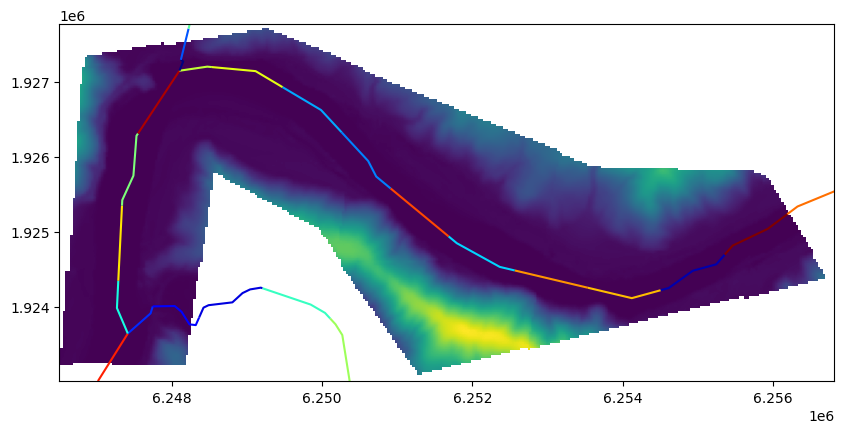

In [23]:
# draw cross section lines up to threshold
fig, ax = plt.subplots(figsize=(10,10))
raster.plot(ax=ax)
segments.plot(ax=ax, cmap=random_cmap(25))
plt.show()

In [24]:
segments.crs

<Projected CRS: EPSG:6418>
Name: NAD83(2011) / California zone 2 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties of Alpine; Amador; Butte; Colusa; El Dorado; Glenn; Lake; Mendocino; Napa; Nevada; Placer; Sacramento; Sierra; Solano; Sonoma; Sutter; Yolo; Yuba.
- bounds: (-124.06, 38.02, -119.54, 40.16)
Coordinate Operation:
- name: SPCS83 California zone 2 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
import xrspatial
from shapely import box, MultiPoint, Point, LineString

aoi = box(*segments.total_bounds)
dem = py3dep.get_map("DEM", aoi, resolution=10, geo_crs="epsg:6418", crs="epsg:4326")
dem = dem.rio.reproject(6418)
slope = xrspatial.slope(dem)
curvature = xrspatial.curvature(dem)
hillshade = xrspatial.hillshade(dem, angle_altitude=25, azimuth=225)

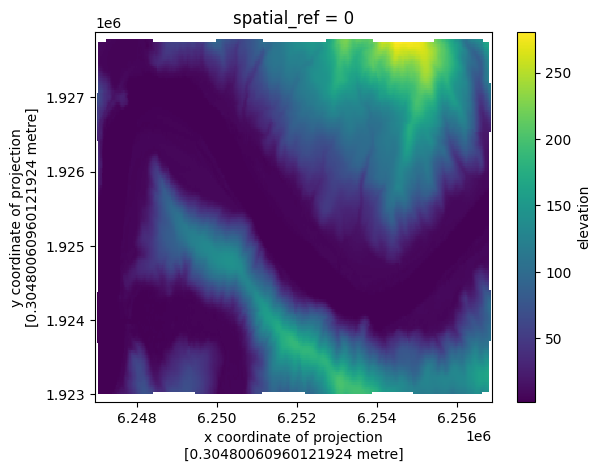

In [30]:
# get basins
dem.plot()

In [32]:
print(aoi)

POLYGON ((6256818.18447396 1923016.0305835565, 6256818.18447396 1927761.5791198495, 6247020.145079231 1927761.5791198495, 6247020.145079231 1923016.0305835565, 6256818.18447396 1923016.0305835565))


In [35]:
# catchment delineation using pysheds

CRS.from_epsg(6418)